# Test transfer learning from Siamese Network to CNN only

## Imports

In [23]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions

In [24]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class

In [25]:
class Config():
    training_dir = "./data/faces_cnn/training/"
    # testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class

In [26]:
class CNNDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)

        if self.transform is not None:
            img0 = self.transform(img0)
        
        return img0, img0_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using IMage Folder Dateset

In [27]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [28]:
siamese_dataset = CNNDataset(imageFolderDataset=folder_dataset,
                            transform=transforms.Compose([transforms.Resize((100,100)),
                                                        transforms.ToTensor()
                                                        ])
                            ,should_invert=False)

print(len(siamese_dataset))
train_dataset, test_dataset = train_set, val_set = torch.utils.data.random_split(siamese_dataset, [340, 60])

400


## Visualising some of the data

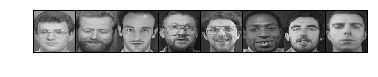

[36 18  7  5 37 14  2 10]


In [29]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
imshow(torchvision.utils.make_grid(example_batch[0]))
print(example_batch[1].numpy())

## Neural Net Definition

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [31]:
class ComparedCNN(nn.Module):
    def __init__(self):
        super(ComparedCNN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

    def forward(self, x):
        output = self.cnn1(x)
        return output

In [32]:
class ComparedCNNwithFC(nn.Module):
    def __init__(self, cnn):
        super(ComparedCNNwithFC, self).__init__()
        self.cnn1 = cnn

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 120),
            # nn.ReLU(inplace=True),

            nn.Linear(120, 84),
            # nn.ReLU(inplace=True),

            nn.Linear(84, 40))

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

## Load Pretain model and freeze CNN

In [33]:
# pretrained_model = SiameseNetwork().cuda()
# pretrained_model.load_state_dict(torch.load("./model"))
# pretrained_model.eval()

# pretrained_dict = pretrained_model.state_dict()

In [34]:
# model_cnn = ComparedCNN().cuda()
# model_dict = model_cnn.state_dict()

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model_cnn.load_state_dict(pretrained_dict)

In [35]:
# model_cnn_fc = ComparedCNNwithFC(model_cnn.requires_grad_(False)).cuda()

## No pretain model

In [36]:
model_cnn = ComparedCNN().cuda()
model_cnn_fc = ComparedCNNwithFC(model_cnn).cuda()

## Loss Function

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn_fc.parameters(), lr=0.001, momentum=0.9)

## Training

In [38]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [39]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 3.7007503509521484

Epoch number 1
 Current loss 2.3135082721710205

Epoch number 2
 Current loss 1.2030138969421387

Epoch number 3
 Current loss 0.34745973348617554

Epoch number 4
 Current loss 0.14209629595279694

Epoch number 5
 Current loss 0.059737712144851685

Epoch number 6
 Current loss 0.03642691671848297

Epoch number 7
 Current loss 0.030960826203227043

Epoch number 8
 Current loss 0.020766450092196465

Epoch number 9
 Current loss 0.018841343000531197

Epoch number 10
 Current loss 0.019052503630518913

Epoch number 11
 Current loss 0.012207507155835629

Epoch number 12
 Current loss 0.012640669010579586

Epoch number 13
 Current loss 0.010105407796800137

Epoch number 14
 Current loss 0.008580351248383522

Epoch number 15
 Current loss 0.009754408150911331

Epoch number 16
 Current loss 0.011572163552045822

Epoch number 17
 Current loss 0.010959398001432419

Epoch number 18
 Current loss 0.006153579335659742

Epoch number 19
 Current loss 0

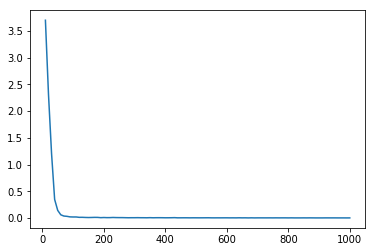

In [40]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, label = data
        img0, label = img0.cuda(), label.cuda()
        optimizer.zero_grad()
        output1 = model_cnn_fc(img0)
        loss_contrastive = criterion(output1,label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Testing

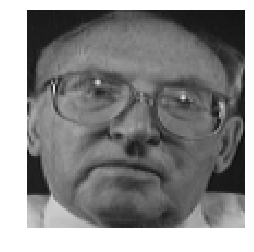

GroundTruth:  31


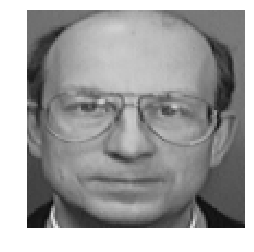

GroundTruth:  8


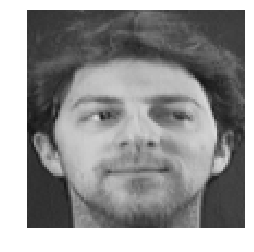

GroundTruth:  41


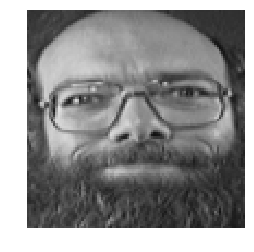

GroundTruth:  34


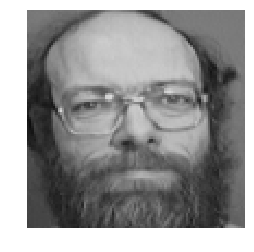

GroundTruth:  34


In [41]:
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

for i in range(5):
    images, labels = next(dataiter)
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', labels[0].numpy()+4)

In [42]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model_cnn_fc(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %
